In [1]:
import pandas as pd
from datetime import datetime

In [2]:
date_parser = pd.to_datetime
red_drum_tag = pd.read_csv("../../../red_drum_weekly_centroid_satellite_class.csv",
                           parse_dates=["week_utc"],
                           skiprows=4)

In [3]:
red_drum_monthly = red_drum_tag.groupby(
    [pd.PeriodIndex(red_drum_tag.week_utc, freq="M"),
     red_drum_tag.tag_id])[["longitude","latitude"]].mean().reset_index()

In [4]:
red_drum_tag.groupby(
    [pd.PeriodIndex(red_drum_tag.week_utc, freq="M"),
     red_drum_tag.tag_id])["n_days_detected"].mean().reset_index().to_csv("mean-days.csv", index=False)

In [5]:
date_range = (min(red_drum_tag.week_utc),
              max(red_drum_tag.week_utc))
date_list = red_drum_tag.week_utc.unique()
lat_range = (min(red_drum_tag.latitude)-1,
             max(red_drum_tag.latitude)+1)
lon_range = (min(red_drum_tag.longitude)-1,
             max(red_drum_tag.longitude+1))

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [7]:
import earthaccess
import xarray as xr

# Login
auth = earthaccess.login()

/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
month_str_list = ["2024-06-01","2024-07-01","2024-08-01","2024-09-01","2024-10-01","2024-11-01","2024-12-01","2025-01-01"]

In [9]:
months = [pd.to_datetime(month_str) for month_str in month_str_list]

In [10]:
results = earthaccess.search_data(
    short_name="MODIS_AQUA_L3_SST_THERMAL_MONTHLY_4KM_DAYTIME_V2019.0",
    temporal=tuple(date_range),
)

results_non_nrt = [r for r in results if "NRT" not in r.data_links()[0]]

In [12]:
fileset = earthaccess.open(results_non_nrt)

QUEUEING TASKS | : 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 1426.39it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████| 8/8 [00:02<00:00,  3.57it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████| 8/8 [00:00<00:00, 72160.07it/s]


In [13]:
datasets = []
for f in fileset:
    time = datetime.strptime(f.info()['name'].split('.')[6][:8], "%Y%m%d")
    dataset = xr.open_dataset(f)
    dataset_chesapeake = dataset.sel(lat=slice(lat_range[1], lat_range[0]),
                       lon=slice(lon_range[0], lon_range[1]))
    dataset_chesapeake["time"] = time
    datasets.append(dataset_chesapeake)

/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:673: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:673: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


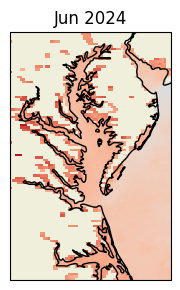

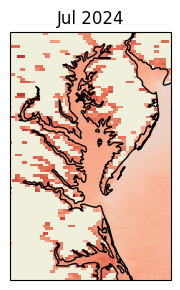

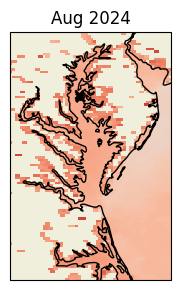

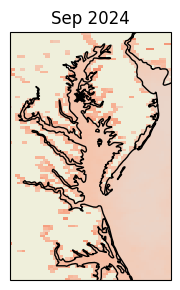

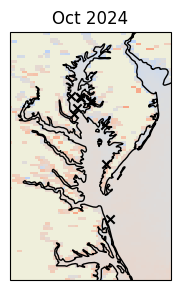

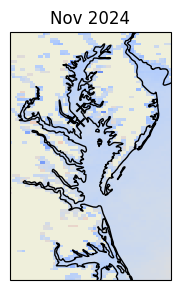

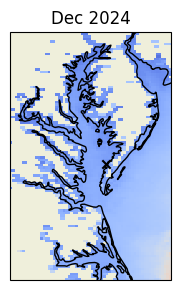

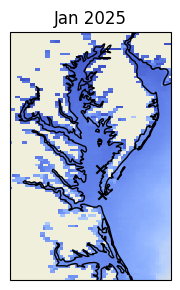

In [14]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=xr.concat(datasets, dim="time")["sst"].min().values.item(0),
                            vmax=xr.concat(datasets, dim="time")["sst"].max().values.item(0))
for ds_month in datasets:
    fig, ax = plt.subplots(figsize=(2,3),
                           subplot_kw={"projection": ccrs.PlateCarree()})

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    month_str = ds_month["time"].dt.strftime("%Y-%m").values.item(0)
    month_str_pretty = ds_month["time"].dt.strftime("%b %Y").values.item(0)
    ax.set_title(month_str_pretty)
    
    ax.set_extent([min(lon_range), max(lon_range),
                   min(lat_range), max(lat_range)])

    mesh = ax.pcolormesh(ds_month.lon, ds_month.lat, ds_month["sst"], cmap="coolwarm",
                         transform=ccrs.PlateCarree(),
                         norm=norm)
    
    ax.scatter(red_drum_monthly.loc[red_drum_monthly.week_utc==month_str, "longitude"],
               red_drum_monthly.loc[red_drum_monthly.week_utc==month_str, "latitude"],
               marker="x",
               color="k")

    plt.tight_layout()

    fig.savefig("sst-{}.pdf".format(month_str))

/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:673: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:673: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


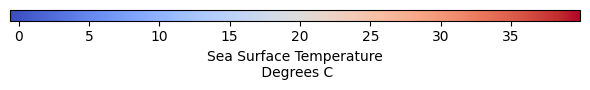

In [27]:
temp_range = (xr.concat(datasets, dim="time")["sst"].min().values.item(0),
              xr.concat(datasets, dim="time")["sst"].max().values.item(0))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colormap and normalization
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=temp_range[0], vmax=temp_range[1])

# Create colorbar without an attached artist
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Sea Surface Temperature\n Degrees C')

plt.tight_layout()

fig.savefig("sst-colorbar.pdf")